In [2]:
import pandas as pd
import numpy as np
from util.cer_util import CER
import util.theory as theory
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.stats import moyal
import time

In [3]:
fitdf = pd.read_csv('./data/fit_data/narrow_lowpitch_fixedsig_fit_data.csv')

In [4]:
langau_params = fitdf[['mpv', 'eta', 'sigma']]
rng = np.random.default_rng()

### Proof of correct invese transform sampling

In [5]:
from landaupy import langauss
params = langau_params.iloc[0]
xrange = np.linspace(0,7,1000)

def sample_from_langau(mpv, eta, sigma, size):
    mpv -= theory.mpv_conv * eta
    return langauss.sample(mpv, eta, sigma, size)

pdf = np.array([ theory.langau_pdf(x, *params) for x in xrange ])
cdf = np.array([ quad(theory.langau_pdf, -np.inf, x, args=tuple(params))[0] for x in xrange ])

In [22]:
def gen_fig(dedx):
    fig = plt.figure(figsize=(12,6.75))
    plt.plot(xrange, pdf, label='langau pdf', lw=3)
    plt.plot(xrange, cdf, label='langau cdf', lw=3)
    plt.xlabel("dE/dx (MeV/cm)", fontsize=16, fontweight='bold')
    plt.xlim(0,6)
    plt.ylim(0,1.75)

    prob = cdf[np.argmin((xrange[:,np.newaxis]-np.repeat(dedx[np.newaxis,:], len(xrange), axis=0))**2, axis=0)]

    plt.plot(np.array([np.zeros(len(prob)), dedx]), np.array([prob,prob]), ls='-.', color='tab:purple', lw=0.8, alpha=0.05)
    plt.plot(np.array([dedx, dedx]), np.array([np.zeros(len(prob)), prob]), ls='-.', color='tab:purple', lw=0.8, alpha=0.1)
    plt.plot(np.array([dedx]), np.array([prob]), marker='o', color='tab:purple', ls='', alpha=0.3)
    # plt.plot(dedx, np.zeros(np.shape(dedx)), marker='o', ls='', color='tab:green', markersize=10, zorder=10, label='MC dE/dx', clip_on=False)
    plt.hist(dedx[dedx<6], np.arange(0,6.1,0.1), color='tab:green', alpha=0.8, edgecolor='black', density=True, label='MC generated \ndE/dx distribution')
    plt.legend(loc='upper left', fontsize=14)
    return fig

/home/samcrossley/anaconda3/envs/pyRoot/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


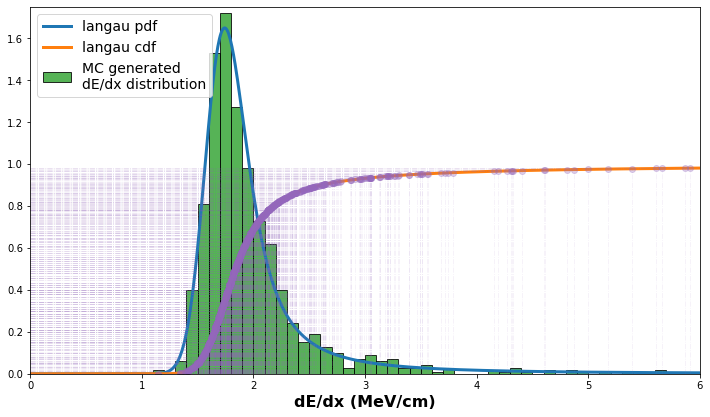

In [23]:
dedx = sample_from_langau(*params, 1000)
fig = gen_fig(dedx)
fig.show()

In [20]:
%%script false --no-raise-error
from tqdm.auto import tqdm
start = 50
step = 50
for i in tqdm(range(len(dedx[start-1:]))):
    if i % step == 0:
        fig = gen_fig(dedx[:i+start])
        fig.savefig(f'temp_plots/mc_generate_example_{(i+start+1)//step}.png', bbox_inches='tight')
        plt.close(fig)

### Generate distribution from which to sample MC track lengths
Uses a lognormal distribution which is fit to the track length histogram in the narrow lowpitch data. This takes a long time as the full dataset must be loaded, so it is only done and the fit values are hardcoded.

In [4]:
%%script false --no-raise-error
cer = CER(full=True, pitch_lims=(0.3, 0.4), angle_given=False, e_lims=(1, 10))
cer.load_muons()
lens = []
for i in cer.muons.index:
    lens.append(cer.muons.dedx_y.loc[i].shape[0])

Loading Data...
Loaded!
Slimming...
Will remove 131967 particles
There are 2675 muons left to analyze


In [5]:
import scipy.stats
from scipy.optimize import curve_fit

def lognorm(x, s, loc, scale):
    return scipy.stats.lognorm.pdf(x, s, loc, scale)

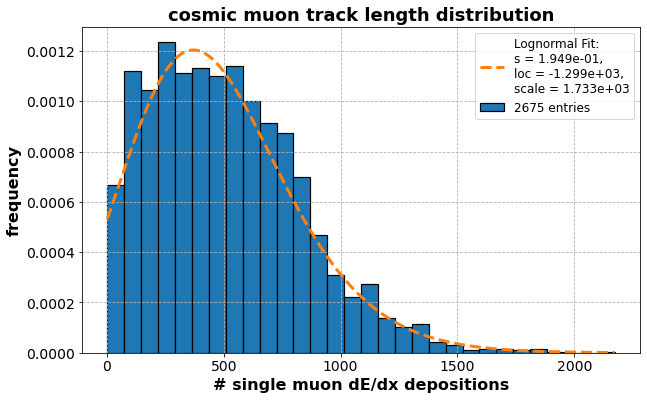

In [28]:
counts, edges = np.histogram(lens, 30, density=True)
bins = (edges[1:] + edges[:-1]) / 2
plt.style.use('stylesheets/eloss.mplstyle')
fig = plt.figure(figsize=(10,6))
plt.hist(bins, edges, weights=counts, lw=1.2, edgecolor='black', alpha=1, label=f'{len(cer.muons.index)} entries')
popt, pcov = curve_fit(lognorm, bins, counts)

x = np.linspace(edges[0], edges[-1], 1000)
plt.plot(x, lognorm(x, *popt), ls='--', lw=3,
         label='Lognormal Fit:\ns = {:.3e}, \nloc = {:.3e}, \nscale = {:.3e}'.format(*popt))
plt.xlabel('# single muon dE/dx depositions')
plt.ylabel('frequency')
plt.title('cosmic muon track length distribution')
plt.legend()
plt.show()
fig.savefig('tracklength_lognormal_fit.png', bbox_inches='tight')

Here we hardcode the data distirubution data from the legend into these parameters, to avoid the long process every time

In [265]:
#                 s               loc              scale             
s, loc, scale = ( 2.01980595e-01, -1.23848172e+03, 1.66933758e+03 )

def rand_trkl():
    val = int(scipy.stats.lognorm.rvs(s, loc, scale))
    while val < 2:
        val = int(scipy.stats.lognorm.rvs(s, loc, scale))
    return val

Proof that this function is accurately reproducing the track length results:

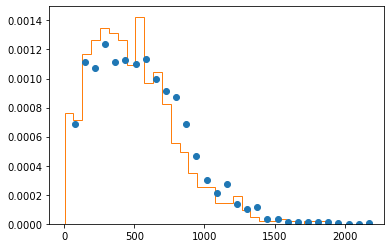

In [276]:
plt.plot(edges[1:], counts, ls='', marker='o')
plt.hist([rand_trkl() for x in range(1000)], bins=30, density=True, histtype='step')
plt.show()

Now we are ready for the MC data production, will make 200 muons in each of the energy bins, select a random track length for each, and for each data point in the track length, select a random dedx value distributed as that langau bin.

In [3]:
%%script false --no-raise-error

muons_per_ebin = 10
start = time.perf_counter()

dedxs_dict = {} 
for i, params in langau_params.iterrows():
    print('Bin '+ str(i) + '...')
    dedxs_per_ebin = []
    for j in range(muons_per_ebin):
        trkl = rand_trkl()
        
        dedxs = []
        for k in range(trkl):
            prob, dedx = sample_from_langau(*params)
            dedxs.append(dedx)
        
        dedxs_per_ebin.append(dedxs)
    dedxs_dict[str(i)] = dedxs_per_ebin
    
print('Generated!')
                 
end = time.perf_counter()
t = end-start
print(f'Total analysis time {int(t//60):d}m {t%60:.1f}s')

In [346]:
def like_max(dedxs):
    landau_params = np.array([ langau_params.iloc[i] for i in range(fitdf.shape[0]) ])
    
    # One big list comprehension for maximum calculation speed
    loglike = np.array([ np.sum([ np.log(theory.langau_pdf(xi, *fj_params)) - np.log(np.sum([ theory.langau_pdf(xi, *fk_params) for fk_params in landau_params])) for xi in dedxs ]) for fj_params in landau_params])
    
    jtilde = np.argmax(loglike)
    e_min_tilde, e_max_tilde = fitdf[['e_min', 'e_max']].iloc[jtilde]
    return e_min_tilde, e_max_tilde, loglike

In [348]:
truth = []
reconstructed = []
loglikes = []
p_count = 0

tot_particles = muons_per_ebin * fitdf.shape[0]
pcnt_per_count = 100./tot_particles
count_per_pcnt = 1/pcnt_per_count
running_count_for_pcnt_increment = 0

print("Generating elosses and reconstructing energy...")
start = time.perf_counter()
for key, value in dedxs_dict.items():
    
    for muon_dedxs in value:
        
        if p_count > running_count_for_pcnt_increment:
            print(f"{(running_count_for_pcnt_increment / tot_particles)*100:.0f}%   ", end = '\r', flush=True)
            running_count_for_pcnt_increment += count_per_pcnt

        p_count += 1
        e_min, e_max, loglike = like_max(muon_dedxs)

        true_e = fitdf[['e_min', 'e_max']].iloc[int(key)].mean()
        truth.append(true_e)

        guess_e = (e_min, e_max)
        reconstructed.append(guess_e)
        loglikes.append(loglike)
    
end = time.perf_counter()
t = end-start
print(f"Done! Analysis time: {int(t//60)}m {t%60:0.1f}s")

Generating elosses and reconstructing energy...
Done! Analysis time: 0m 39.3s


In [357]:
like_data_dict = []
for i in range(len(truth)):
    t = truth[i]
    re_min = reconstructed[i][0]
    re_max = reconstructed[i][1]
    
    this_dict = {'truth': t, 'reconstructed_min': re_min, 'reconstructed_max': re_max}
    
    for j in range(len(loglikes[i])):
        like = loglikes[i][j]
        this_dict[f'L{j}'] = like
    
    like_data_dict.append(this_dict)

save=False
if save:
    print("Saving likelihood data...")
    like_data = pd.DataFrame.from_dict(like_data_dict)
    like_data.to_csv(rf'../data/reconstructions/{save}', index=False, header=True)
    print('Saved!')

In [11]:
def sample_from_langau(rng, mpv, eta, sigma):
    prob = rng.uniform()
    to_solve = lambda b: quad(theory.langau_pdf, -np.inf, b, args=(mpv, eta, sigma))[0]-prob
    dedx = fsolve(to_solve, 2)[0]
    return dedx

In [12]:
def sample_from_langauss(mpv, eta, sigma, size):
    mpv -= theory.mpv_conv * eta
    return langauss.sample(mpv, eta, sigma, size)

In [13]:
%timeit sample_from_langau(rng, mpv, eta, sigma)

/home/samcrossley/anaconda3/envs/pyRoot/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/samcrossley/anaconda3/envs/pyRoot/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/samcrossley/anaconda3/envs/pyRoot/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


11 ms ± 980 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit sample_from_langauss(mpv, eta, sigma, 1000)

4.89 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


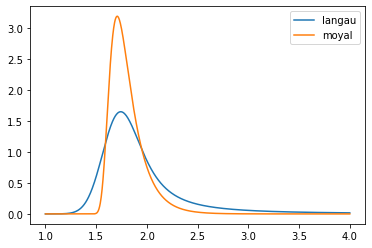

In [4]:
import pylandau as pl
mpv, eta, sigma = langau_params.iloc[0]
x = np.linspace(1,4, 1000)
y = theory.langau_pdf(x, mpv, eta, sigma)
ym = moyal.pdf(x, mpv, eta)
plt.plot(x, y, label='langau')
plt.plot(x, ym, label='moyal')
plt.legend()

In [15]:
from landaupy import langauss

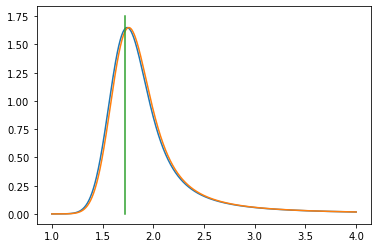

In [29]:
ylp = langauss.pdf(x, mpv, eta, sigma)
plt.plot(x,y)
plt.plot(x,ylp)
plt.plot([mpv+0.22278298*eta]*2, [0,1.75])

In [30]:
from scipy.optimize import minimize

In [38]:
langau_mpv = minimize(lambda x: -theory.langau_pdf(x, mpv, eta, sigma), 1.5).x
langauss_mpv = minimize(lambda x: -langauss.pdf(x, mpv, eta, sigma), 1.5).x
print((langauss_mpv - langau_mpv)[0])
print(0.22278298*eta)

0.016890303793220873
0.016890297348482807


In [5]:
import util.theory as th

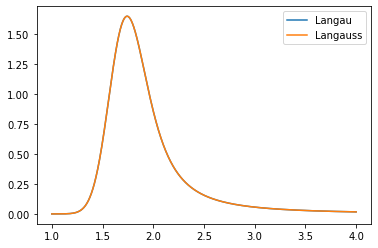

In [8]:
ypl = th.langau_pdf(x, mpv, eta, sigma)
ylp = th.langauss_pdf(x, mpv, eta, sigma)
plt.plot(x, th.langau_pdf(x, mpv, eta, sigma), label='Langau')
plt.plot(x, th.langauss_pdf(x, mpv, eta, sigma), label='Langauss')
plt.legend()

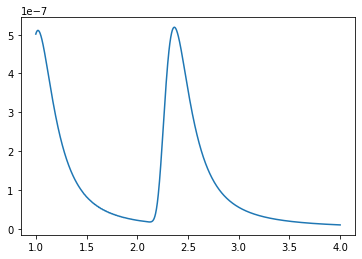

In [10]:
plt.plot(x, ypl-ylp)